In [1]:
import os 
import json
from datetime import datetime

import math
import numpy as np

from utils.input import setup, exercise_to_input

# Setttings

In [2]:
data_set = 'patients_with_age'
# 'healthy'
# 'patients'
# 'patients_with_age'

In [3]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [4]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', data_set)

In [5]:
CONFIG = setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

In [6]:
CONFIG

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

# Load all the sessions

In [7]:
def get_patient_id(file):
    return file.split('_')[0]

In [8]:
def get_session_id(file):
    return file.split('_')[1]

load all the sessions to a dictionary

In [9]:
patients_sessions = {}
exercises = {}
age_groups = {}
non_counter = 0
age_counter = 0

for file_name in os.listdir(dir_exercises):
    if file_name == '.DS_Store': continue
    
    exercise = json.load(open(os.path.join(dir_exercises, file_name), 'r'))
    
    patient_id = get_patient_id(file_name)
    session_id = get_session_id(file_name)
    exercise_id = exercise['meta']['id']
    exercises[exercise_id] = exercise['meta']['name']

    if exercise['meta']['age'] != 'None':
        age_counter += 1
        age_group = float(exercise['meta']['age'])//10
    else:
        non_counter += 1
        continue
    
    if age_group not in age_groups:
        age_groups[age_group] = []
    age_groups[age_group].append(patient_id)   
    
    if patient_id not in patients_sessions:
        patients_sessions[patient_id] = {}
        
    if session_id not in patients_sessions[patient_id]:
        patients_sessions[patient_id][session_id] = {}
        
    data = []
    
    for poi in sorted(CONFIG['REGIONS'].keys()):
        if poi not in exercise['pois']:
            print(f'!WARNING: {poi} is not present in {file_name}')
            continue
            
        data.append({
            'xs': exercise['pois'][poi]['xs'],
            'ys': exercise['pois'][poi]['ys'],
            'zs': exercise['pois'][poi]['zs']
        })
        
    patients_sessions[patient_id][session_id][exercise_id] = data    


print(f'Exercises with age: {age_counter} without age: {non_counter}')

Exercises with age: 1306 without age: 1113


# Observations

In [10]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [11]:
def patient_amount(data):
    return len(data)

In [12]:
def sessions_amount(data):
    sessions = 0
    for patient_id in data:
        sessions += len(data[patient_id])
    
    return sessions

In [13]:
print(f'Overal number of patients:{patient_amount(patients_sessions)}')

Overal number of patients:73


In [14]:
print(f'Overal number of sessions:{sessions_amount(patients_sessions)}')

Overal number of sessions:165


In [15]:
print('List of exercises:')

for key in sorted(exercises.keys()):
    print(exercises[key])

List of exercises:
RaisingEyebrows
Frowing
ClosingEyes
Smiling
BaringTeeth
PursingLips
BlowingOutCheeks
ClosingEyesBaringTeeth
RaisingEyebrowsPursingLips


In [16]:
for key in sorted(age_groups.keys()):
    print(f'key: {int(key)} ages {key * 10}-{key * 10 + 9} participants {len(age_groups[key])}')

key: 2 ages 20.0-29.0 participants 70
key: 3 ages 30.0-39.0 participants 156
key: 4 ages 40.0-49.0 participants 242
key: 5 ages 50.0-59.0 participants 267
key: 6 ages 60.0-69.0 participants 386
key: 7 ages 70.0-79.0 participants 185


## Exercises length distribution

In [17]:
def get_sessions_lengts(data):
    lengths = []
    for patient_id in data:
        for session_id in data[patient_id]:
            for exercise_id in data[patient_id][session_id]:
                lengths.append(len(data[patient_id][session_id][exercise_id][0]['xs']))
    return lengths

Number of exercises: 1306


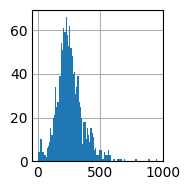

In [18]:
dist = get_sessions_lengts(patients_sessions)

print(f'Number of exercises: {len(dist)}')

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.hist(dist, bins=100)
plt.show()

In [19]:
def show_problematic_exercises(data, lower_limit=100):
    lengths = []
    for patient_id in data:
        for session_id in data[patient_id]:
            for exercise_id in data[patient_id][session_id]:
                if len(data[patient_id][session_id][exercise_id][0]['xs']) < lower_limit:
                    print(f'Short exercise: Patient {patient_id} Session {session_id} Exercise {exercise_id}')

In [20]:
show_problematic_exercises(patients_sessions, lower_limit = 50)

Short exercise: Patient 58 Session 17 Exercise 03
Short exercise: Patient 35 Session 131 Exercise 07
Short exercise: Patient 35 Session 129 Exercise 06
Short exercise: Patient 35 Session 129 Exercise 07
Short exercise: Patient 35 Session 129 Exercise 03
Short exercise: Patient 35 Session 129 Exercise 08
Short exercise: Patient 35 Session 129 Exercise 04
Short exercise: Patient 35 Session 129 Exercise 05
Short exercise: Patient 35 Session 129 Exercise 09
Short exercise: Patient 40 Session 155 Exercise 06
Short exercise: Patient 1 Session 77 Exercise 05
Short exercise: Patient 13 Session 165 Exercise 02
Short exercise: Patient 13 Session 165 Exercise 03
Short exercise: Patient 13 Session 165 Exercise 04
Short exercise: Patient 13 Session 165 Exercise 08
Short exercise: Patient 13 Session 165 Exercise 09
Short exercise: Patient 13 Session 165 Exercise 05
Short exercise: Patient 13 Session 165 Exercise 06
Short exercise: Patient 13 Session 165 Exercise 07
Short exercise: Patient 13 Session

# Visualise excercises

In [21]:
import tsaug
from tsaug.visualization import plot

In [22]:
exercise_id = 0
poi_id = 2

In [23]:
def exercise_min_max(data):
    min_xs = 2
    max_xs = -2
    min_ys = 2
    max_ys = -2
    min_zs = 2
    max_zs = -2
    for patient_id in sorted(data.keys()):
        for session_id in data[patient_id]:
            if exercise_id in data[patient_id][session_id]:
                for serieses in data[patient_id][session_id][exercise_id]:
                    min_xs = min([min_xs, min(serieses['xs'])])
                    max_xs = max([max_xs, max(serieses['xs'])])
                    min_ys = min([min_ys, min(serieses['ys'])])
                    max_ys = max([max_ys, max(serieses['ys'])])
                    min_zs = min([min_zs, min(serieses['zs'])])
                    max_zs = max([max_zs, max(serieses['zs'])])
    print(f'min_xs = {min_xs}')
    print(f'max_xs = {max_xs}')
    print(f'min_ys = {min_ys}')
    print(f'max_ys = {max_ys}')
    print(f'min_zs = {min_zs}')
    print(f'max_zs = {max_zs}')

In [24]:
exercise_min_max(patients_sessions)

min_xs = 2
max_xs = -2
min_ys = 2
max_ys = -2
min_zs = 2
max_zs = -2


In [25]:
def exercise_serieses(data):
    for patient_id in sorted(data.keys()):
        for session_id in data[patient_id]:
            if exercise_id in data[patient_id][session_id]:
                series = np.array(data[patient_id][session_id][exercise_id][poi_id]['xs'])
                #print(patient_id)
                plot(series)

In [26]:
#exercise_serieses(patients_sessions)

Weird! the healthy patient data doesn't look as data we had. We need to dig deeper

# Descriptive statistics

In [27]:
from utils.transformations import distance
import pandas as pd

In [28]:
target_poi = 'LefteyeMidbottom'

In [29]:
POIS = sorted(CONFIG['REGIONS'].keys())

In [30]:
def collect_stats(exercise):
    if 'age' not in exercise['meta']:
        return None
    if exercise['meta']['age'] == 'None':
        return None        
        
    data = {}
    data['age_bucket'] = float(exercise['meta']['age']) // 10
    data['exercise_id'] = int(exercise['meta']['id'])
    data['sex'] = exercise['meta']['sex'] == 'SexEnum.FEMALE'
    data['length'] = 1.0 * len(exercise['pois'][target_poi]['xs'])
    
    for poi in POIS:
        data[f'distance_{poi}'] = sum(distance(
            exercise['pois'][poi]['xs'],
            exercise['pois'][poi]['ys'],
            exercise['pois'][poi]['zs']))
        data[f'distance_norm_{poi}'] = data[f'distance_{poi}'] / data['length']
    total_distance = 0
    for poi in POIS:
        total_distance += data[f'distance_{poi}']
    data[f'distance_total'] = total_distance
    data[f'distance_total'] = total_distance
    data[f'distance_norm_total'] = total_distance / data['length']
    
    left_distance = 0
    for poi in CONFIG['SIDES']['left']:
        left_distance += data[f'distance_{poi}']
    data[f'distance_left'] = left_distance    
    data[f'distance_norm_left'] = left_distance / data['length']
    right_distance = 0
    for poi in CONFIG['SIDES']['right']:
        right_distance += data[f'distance_{poi}']
    data[f'distance_right'] = right_distance  
    data[f'distance_norm_right'] = right_distance / data['length']
    data[f'distance_norm_assymetry'] = abs((left_distance / data['length']) - (right_distance / data['length']))

    return data

In [31]:
stats = []

In [32]:
for file_name in os.listdir(dir_exercises):
    if file_name == '.DS_Store': continue
    
    exercise = json.load(open(os.path.join(dir_exercises, file_name), 'r')) 
    stat = collect_stats(exercise)
    if stat:
        stats.append(collect_stats(exercise))

In [33]:
df = pd.DataFrame.from_records(stats)

In [34]:
df.head()

,age_bucket,exercise_id,sex,length,distance_ChinCenter,distance_norm_ChinCenter,distance_ForeheadCenter,distance_norm_ForeheadCenter,distance_LeftcheekCenter,distance_norm_LeftcheekCenter,...,distance_norm_RighteyebrowCenter,distance_RighteyebrowInner,distance_norm_RighteyebrowInner,distance_total,distance_norm_total,distance_left,distance_norm_left,distance_right,distance_norm_right,distance_norm_assymetry
0,4.0,1,True,367.0,0.390273,0.001063,0.332077,0.000905,0.305101,0.000831,...,0.000957,0.337493,0.000920,6.765142,0.018434,2.508448,0.006835,2.481853,0.006763,0.000072
1,4.0,1,True,53.0,0.062233,0.001174,0.059646,0.001125,0.057275,0.001081,...,0.001088,0.056785,0.001071,1.211853,0.022865,0.461167,0.008701,0.447976,0.008452,0.000249
2,5.0,5,True,212.0,0.311109,0.001467,0.200918,0.000948,0.245799,0.001159,...,0.000992,0.195911,0.000924,4.518194,0.021312,1.651711,0.007791,1.634189,0.007708,0.000083
3,4.0,9,False,219.0,0.331467,0.001514,0.213671,0.000976,0.202946,0.000927,...,0.001059,0.233646,0.001067,4.565015,0.020845,1.686101,0.007699,1.614190,0.007371,0.000328
4,6.0,7,False,202.0,0.421461,0.002086,0.294774,0.001459,0.338088,0.001674,...,0.001416,0.266038,0.001317,6.426416,0.031814,2.389149,0.011827,2.320991,0.011490,0.000337


In [35]:
exercise_titles = {
    1: 'Raising Eyebrows',
    2: 'Frowing',
    3: 'Closing Eyes',
    4: 'Smiling',
    5: 'Baring Teeth',
    6: 'Pursing Lips',
    7: 'Blowing\nOut Cheeks',
    8: 'Closing\nEyes Baring Teeth',
    9: 'Raising\nEyebrows Pursing Lips'
}

In [36]:
def visualise_stats(stat, max_y = 100, title='', y_title=0.98):
    fig, axs = plt.subplots(3,3,figsize=(8,8)) 
    columns = ['age_bucket', stat]
    for exercise_id in range(0, 9):
        row = exercise_id // 3
        col = exercise_id - (row * 3 )
        ex_df = df.loc[df['exercise_id'] == exercise_id + 1][columns]
        plot = ex_df.boxplot(by='age_bucket', ax=axs[row][col], patch_artist=True)
        plot.set_title(f'Exercise: {exercise_titles[exercise_id + 1]}')
        plot.set_ylim([0, max_y])
    #plt.xticks(rotation=90)
    plt.tight_layout() 
    fig.suptitle(title, y = y_title, fontsize=15)
    plt.show()
    fig.savefig(f'plot_{stat}.svg', format='svg', dpi=1200)



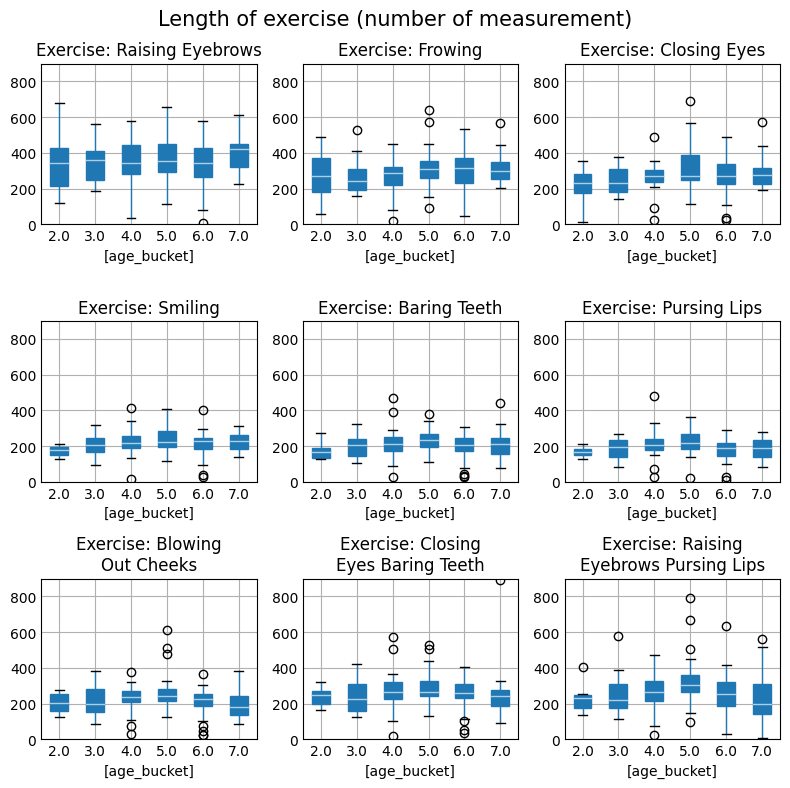

In [37]:
visualise_stats('length', 
                title='Length of exercise (number of measurement)', 
                max_y = 900)

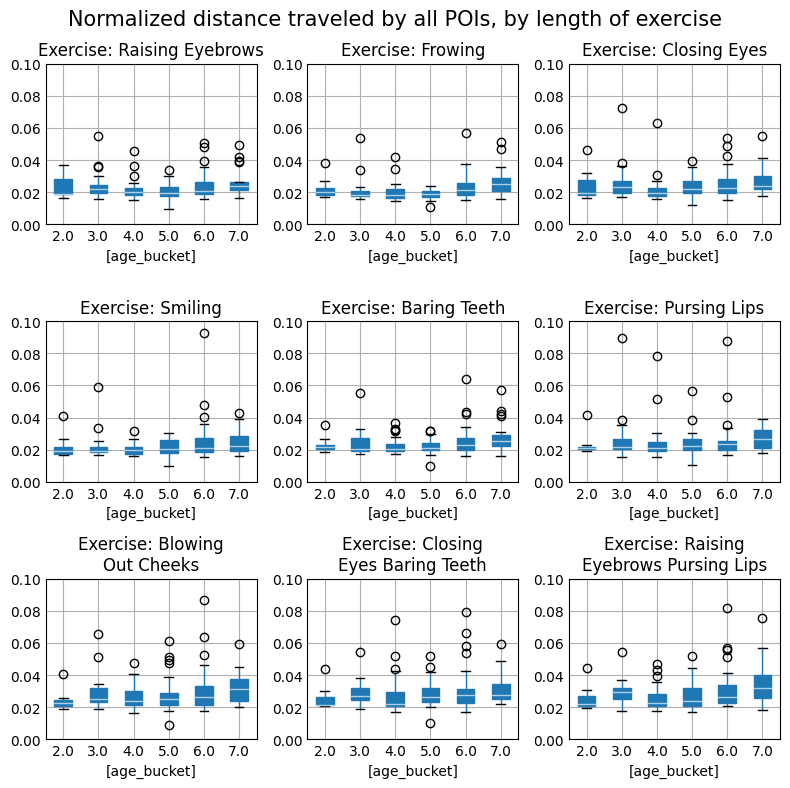

In [38]:
visualise_stats('distance_norm_total',
                title='Normalized distance traveled by all POIs, by length of exercise', 
                max_y = 0.1)


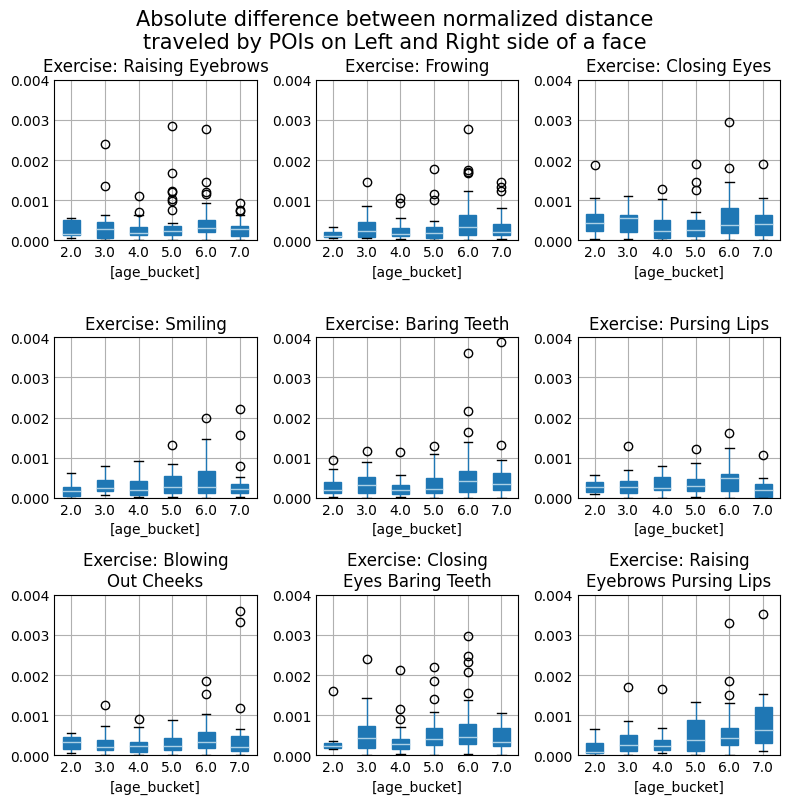

In [39]:
visualise_stats('distance_norm_assymetry', 
                title='Absolute difference between normalized distance\ntraveled by POIs on Left and Right side of a face',
                y_title = 1,
                max_y = 0.004)

In [40]:
pd.set_option('display.float_format', lambda x: '%.15f' % x)

In [41]:
stat = 'distance_norm_assymetry'
columns = ['age_bucket', stat]
for exercise_id in range(0, 9):
    ex_df = df.loc[df['exercise_id'] == exercise_id + 1][columns]
    ex_df['age_bucket'] = pd.to_numeric(ex_df['age_bucket'], downcast='integer')
    print(ex_df.groupby('age_bucket').var())

            distance_norm_assymetry
age_bucket                         
2                 0.000000041265188
3                 0.000000321473857
4                 0.000000064584385
5                 0.000000346593383
6                 0.000000974660965
7                 0.000000063734796
            distance_norm_assymetry
age_bucket                         
2                 0.000000010097891
3                 0.000000126318886
4                 0.000000062766779
5                 0.000000134745607
6                 0.000000317223742
7                 0.000000169623901
            distance_norm_assymetry
age_bucket                         
2                 0.000000361448738
3                 0.000000081543267
4                 0.000000133282547
5                 0.000000186915343
6                 0.000000330466396
7                 0.000000185740254
            distance_norm_assymetry
age_bucket                         
2                 0.000000047378667
3                 0.00000004

In [42]:
from statistics import mean 

m = mean([
    0.000000005021577,
    0.000000046507474,
    0.000000683979395,
    0.000000245467460,
    0.000000128163981,
    0.000000598133059,
])

m

2.84545491e-07

In [43]:

0.000003048307622
0.000004309625733

4.309625733e-06